In [19]:
# -*- coding: utf-8 -*-

import pandas as pd  # 导入数据分析库Pandas
from scipy.interpolate import lagrange  # 导入拉格朗日插值函数

inputfile = '../data/catering_sale.xls'  # 销量数据路径
outputfile = '../tmp/sales.xls'  # 输出数据路径

data = pd.read_excel(inputfile)  # 读入数据
print(data.describe)
data['销量'][(data['销量'] < 400) | (data['销量'] > 5000)] = None  # 过滤异常值，将其变为空值

print (data,'---')

# 自定义列向量插值函数
# s为列向量，n为被插值的位置，k为取前后的数据个数，默认为5
def ployinterp_column(s, n, k=5):
#   print (s,'---s')
#   print (list(range(n-k, n)),'---')
#   print (list(range(n+1, n+1+k)),'--list')
#   print (list(range(n-k, n)) + list(range(n+1, n+1+k)))
  y = s.iloc[list(range(n-k, n)) + list(range(n+1, n+1+k))]  # 取数
#   print (y,'---y')
  y = y[y.notnull()]  # 剔除空值
  return lagrange(y.index, list(y))(n)  # 插值并返回插值结果

# 逐个元素判断是否需要插值
for i in data.columns:
  print (i,'---i')
  for j in range(len(data)):
    if (data[i].isnull())[j]:  # 如果为空即插值。
      data[i][j] = ployinterp_column(data[i], j)

data.to_excel(outputfile)  # 输出结果，写入文件

<bound method NDFrame.describe of             日期      销量
0   2015-03-01    51.0
1   2015-02-28  2618.2
2   2015-02-27  2608.4
3   2015-02-26  2651.9
4   2015-02-25  3442.1
..         ...     ...
196 2014-08-06  2915.8
197 2014-08-05  2618.1
198 2014-08-04  2993.0
199 2014-08-03  3436.4
200 2014-08-02  2261.7

[201 rows x 2 columns]>
            日期      销量
0   2015-03-01     NaN
1   2015-02-28  2618.2
2   2015-02-27  2608.4
3   2015-02-26  2651.9
4   2015-02-25  3442.1
..         ...     ...
196 2014-08-06  2915.8
197 2014-08-05  2618.1
198 2014-08-04  2993.0
199 2014-08-03  3436.4
200 2014-08-02  2261.7

[201 rows x 2 columns] ---
日期 ---i
销量 ---i


<ipython-input-19-7b20b0125bb2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['销量'][(data['销量'] < 400) | (data['销量'] > 5000)] = None  # 过滤异常值，将其变为空值
<ipython-input-19-7b20b0125bb2>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i][j] = ployinterp_column(data[i], j)


In [16]:
# 代码4-2  数据规范化
import pandas as pd
import numpy as np
datafile = '../data/normalization_data.xls'  # 参数初始化
data = pd.read_excel(datafile, header = None)  # 读取数据
print(data)

(data - data.min()) / (data.max() - data.min())  # 最小-最大规范化
(data - data.mean()) / data.std()  # 零-均值规范化
data / 10 ** np.ceil(np.log10(data.abs().max()))  # 小数定标规范化



     0    1    2     3
0   78  521  602  2863
1  144 -600 -521  2245
2   95 -457  468 -1283
3   69  596  695  1054
4  190  527  691  2051
5  101  403  470  2487
6  146  413  435  2571


,0,1,2,3
0,0.078,0.521,0.602,0.2863
1,0.144,-0.600,-0.521,0.2245
2,0.095,-0.457,0.468,-0.1283
3,0.069,0.596,0.695,0.1054
4,0.190,0.527,0.691,0.2051
5,0.101,0.403,0.470,0.2487
6,0.146,0.413,0.435,0.2571


/Users/huangtianlin/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


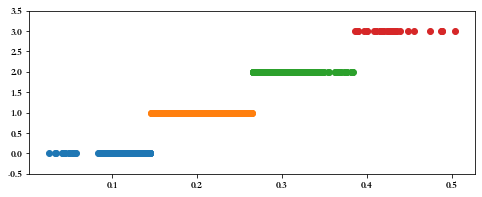

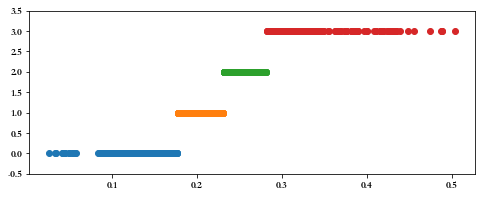

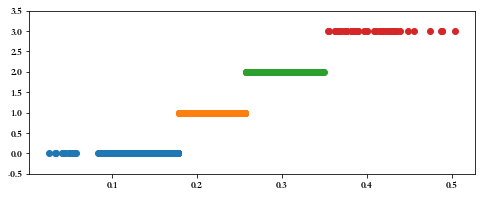

In [1]:
# 代码4-3  数据离散化
import pandas as pd
import numpy as np
datafile = '../data/discretization_data.xls'  # 参数初始化
data = pd.read_excel(datafile)  # 读取数据
data = data['肝气郁结证型系数'].copy()
k = 4

d1 = pd.cut(data, k, labels = range(k))  # 等宽离散化，各个类比依次命名为0,1,2,3

#等频率离散化
w = [1.0*i/k for i in range(k+1)]
w = data.describe(percentiles = w)[4:4+k+1]  # 使用describe函数自动计算分位数
w[0] = w[0]*(1-1e-10)
d2 = pd.cut(data, w, labels = range(k))

from sklearn.cluster import KMeans  # 引入KMeans
kmodel = KMeans(n_clusters = k, n_jobs = 4)  # 建立模型，n_jobs是并行数，一般等于CPU数较好
kmodel.fit(np.array(data).reshape((len(data), 1)))  # 训练模型
c = pd.DataFrame(kmodel.cluster_centers_).sort_values(0)  # 输出聚类中心，并且排序（默认是随机序的）
w = c.rolling(2).mean()  # 相邻两项求中点，作为边界点
w = w.dropna()
w = [0] + list(w[0]) + [data.max()]  # 把首末边界点加上
d3 = pd.cut(data, w, labels = range(k))
def cluster_plot(d, k):  # 自定义作图函数来显示聚类结果
  import matplotlib.pyplot as plt
  plt.rcParams['font.sans-serif'] = ['Songti SC']  # 用来正常显示中文标签
  plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
  
  plt.figure(figsize = (8, 3))
  for j in range(0, k):
    plt.plot(data[d==j], [j for i in d[d==j]], 'o')
  
  plt.ylim(-0.5, k-0.5)
  return plt

cluster_plot(d1, k).show()
cluster_plot(d2, k).show()
cluster_plot(d3, k).show()

In [20]:
# 参数初始化
inputfile= '../data/electricity_data.xls'  # 供入供出电量数据
outputfile = '../tmp/electricity_data.xls'  # 属性构造后数据文件

data = pd.read_excel(inputfile)  # 读入数据
data['线损率'] = (data['供入电量'] - data['供出电量']) / data['供入电量']

data.to_excel(outputfile, index = False)  # 保存结果

In [22]:
inputfile= '../data/leleccum.mat'  # 提取自Matlab的信号文件

from scipy.io import loadmat  # mat是Python专用格式，需要用loadmat读取它
mat = loadmat(inputfile)
signal = mat['leleccum'][0]

import pywt  # 导入PyWavelets
coeffs = pywt.wavedec(signal, 'bior3.7', level = 5)
# 返回结果为level+1个数字，第一个数组为逼近系数数组，后面的依次是细节系数数组

In [23]:
# 参数初始化
inputfile = '../data/principal_component.xls'
outputfile = '../tmp/dimention_reducted.xls'  # 降维后的数据

data = pd.read_excel(inputfile, header = None)  # 读入数据

from sklearn.decomposition import PCA

pca = PCA()
pca.fit(data)

pca.components_  # 返回模型的各个特征向量


pca.explained_variance_ratio_  # 返回各个成分各自的方差百分比




# 代码4-7 计算成分结果
pca = PCA(3)
pca.fit(data)
low_d = pca.transform(data)  # 用它来降低维度
pd.DataFrame(low_d).to_excel(outputfile)  # 保存结果
pca.inverse_transform(low_d)  # 必要时可以用inverse_transform()函数来复原数据

low_d

array([[  8.19133694,  16.90402785,   3.90991029],
       [  0.28527403,  -6.48074989,  -4.62870368],
       [-23.70739074,  -2.85245701,  -0.4965231 ],
       [-14.43202637,   2.29917325,  -1.50272151],
       [  5.4304568 ,  10.00704077,   9.52086923],
       [ 24.15955898,  -9.36428589,   0.72657857],
       [ -3.66134607,  -7.60198615,  -2.36439873],
       [ 13.96761214,  13.89123979,  -6.44917778],
       [ 40.88093588, -13.25685287,   4.16539368],
       [ -1.74887665,  -4.23112299,  -0.58980995],
       [-21.94321959,  -2.36645883,   1.33203832],
       [-36.70868069,  -6.00536554,   3.97183515],
       [  3.28750663,   4.86380886,   1.00424688],
       [  5.99885871,   4.19398863,  -8.59953736]])

In [24]:
D = pd.Series([1, 1, 2, 3, 5])
D.unique()
np.unique(D)

array([1, 2, 3, 5])

In [25]:
# 代码 4-9 对一个10×4维的随机矩阵进行主成分分析
from sklearn.decomposition import PCA
D = np.random.rand(10,4)
pca = PCA()
pca.fit(D)
pca.components_  # 返回模型的各个特征向量
pca.explained_variance_ratio_  # 返回各个成分各自的方差百分比

array([0.47546556, 0.34738792, 0.13361728, 0.04352924])